## By Thomas Torku based on yfinance from Jean Cruz

In [10]:
import keras
import tensorflow as tf
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =6,6
from datetime import datetime

## Grab Data

In [11]:
def getstock(name):
    t = yf.Ticker(name)
    dat = t.history(period='max')
    return np.array(dat['Open'][-3900:])
# np.array(dat['Open'][-5900:])

In [12]:
yf.Ticker('AAPL').history(period='max')

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12,0.41,0.41,0.41,0.41,117258400,0.0,0.0
1980-12-15,0.39,0.39,0.39,0.39,43971200,0.0,0.0
1980-12-16,0.36,0.36,0.36,0.36,26432000,0.0,0.0
1980-12-17,0.37,0.37,0.37,0.37,21610400,0.0,0.0
1980-12-18,0.38,0.38,0.38,0.38,18362400,0.0,0.0
...,...,...,...,...,...,...,...
2020-03-17,247.51,257.61,238.40,252.86,81014000,0.0,0.0
2020-03-18,239.77,250.00,237.12,246.67,75058400,0.0,0.0
2020-03-19,247.39,252.84,242.61,244.78,67964300,0.0,0.0


## Visualize the Open Prices of the 8 Stocks

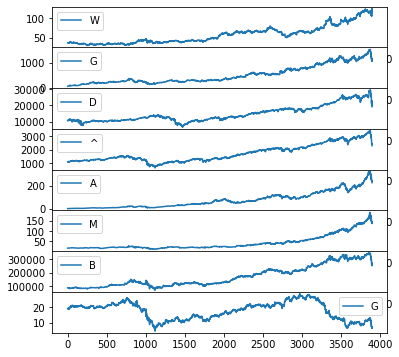

In [13]:
stocks = ['WMT', 'GOOG', 'DJI', '^GSPC', 'AAPL', 'MSFT', 'BRK-A', 'GE'] #Grab 8 stocks
dat = np.array([getstock(n) for n in stocks])
#Graph them
fig, ax=plt.subplots(8,1)
fig.subplots_adjust(hspace=0)
for i in range(len(stocks)):
    ax[i].plot(dat[i])
    ax[i].legend(str(stocks[i]), loc='best')

## Normalize the data

In [14]:
def norm(data, window_width, timesteps):
    """
    window_width: length of data for moving forward in time
    timestps for predicting future prices
    """
    x = np.array([dat[:,i:i+window_width]/dat[:,i, None]  for i in range(dat.shape[1] - window_width - 1)])
    y = np.array([dat[:,i+window_width]/dat[:,i]  for i in range(dat.shape[1] - window_width - 1)])
    return x, y
x, y =norm(dat, 200, 1)

In [15]:
y.shape

(3699, 8)

## The Feed-Forward or Deep (DNN Model)

In [16]:
from keras.models import Sequential
model = Sequential()
model.add(keras.layers.Dense(4096, activation='relu', input_shape=[x.shape[1], x.shape[2]]))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(y.shape[1], activation='linear'))
model.compile(loss=keras.losses.mean_squared_error,
             optimizer=keras.optimizers.Nadam(learning_rate=0.001),
             metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8, 4096)           823296    
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 262152    
Total params: 1,085,448
Trainable params: 1,085,448
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(x, y, batch_size=64, epochs=60, verbose=0, validation_split=0.2)

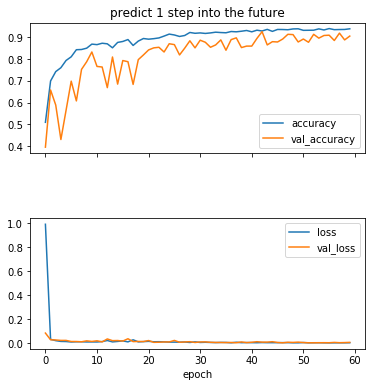

In [18]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.subplots_adjust(hspace=0.5)
ax1.title.set_text(f'predict 1 step into the future')

ax1.plot(history.history['accuracy'], label='accuracy')
ax1.plot(history.history['val_accuracy'], label='val_accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='loss')
ax2.plot(history.history['val_loss'], label='val_loss')
ax2.legend()

ax2.set_xlabel('epoch')
print()

In [19]:
score= model.evaluate(x, y, verbose=0)
print('Training Loss', score[0])
print('Training  Accuracy', score[1])

Training Loss 0.004393277963496005
Training  Accuracy 0.9251148700714111


## Prdeiction

In [20]:
inp = x[-1].reshape((1, dat.shape[0], 200))
p = model.predict(inp).reshape(dat.shape[0])
# pp = model.predict(inp)
print('recent:     ', inp[0,:,-1])
print('expected:   ', y[-1])
print('prediction: ', p)

recent:      [1.22814289 1.03947544 0.75255751 0.84932703 1.35481928 1.15351054
 0.8224697  0.63808574]
expected:    [1.17919874 1.08005402 0.75967884 0.86297457 1.35366922 1.17960734
 0.86799869 0.69890329]
prediction:  [1.194851   1.09965    1.0075641  1.0040336  1.4114528  1.2018982
 0.9842693  0.95318407]


## More Performance Metric: MAE, RMSE

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y[-1], p))
mae =mean_absolute_error(y[-1],p)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)

RMSE: 0.143
MAE: 0.109


## Graphs

(740, 1)
(2959, 1)
1.105287574269198


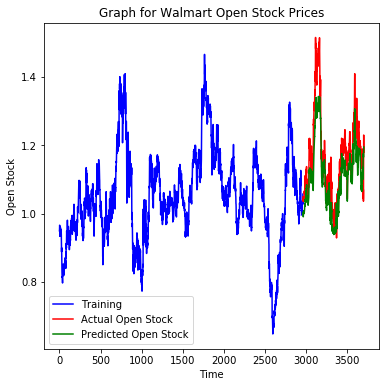

In [22]:
#Use the original data of the first stock
import pandas as pd
import scipy.stats as st
import math
ind =int(0.8*len(y))
dt0=pd.DataFrame(y[:,0])    #first stock
dt=x[:,0:8:,]
train_x, test_x =dt[:ind,0:8:,], dt[ind:,0:8:,]
train_y, test_y =dt0[:ind], dt0[ind:]
pred_y =model.predict(test_x)
ppy =pred_y[:,0]
#ppy=pd.DataFrame(pred_y[:,0], index=test_y.index)
fc_series =pd.Series(pred_y[:,0], index=test_y.index)
print(test_y.shape)
print(train_y.shape)
# print(fc_.shape)
def conf_int(fc_serie, ci):
#     n=fc_series.count()
    arr=np.array(fc_serie)
    n =len(fc_series)
    #rint(n)
    for i in range(n):
        xbar =np.mean(arr, axis=0)
        
        xstd=np.std(arr, axis=0)
        ts=st.t.ppf((ci +1)/2,n)
        lb =xbar-(ts*(xstd/math.sqrt(n)))
        ub =xbar+(ts*(xstd/math.sqrt(n)))
    return lb, ub
lb, ub =conf_int(ppy,0.95)


#Construct the confidence interval
plt.plot(train_y, 'b')
plt.plot(test_y, 'r')
plt.plot(fc_series, 'g')
#plt.fill_between(fc_series.index, lb,ub, color='k', alpha=0.20)
plt.xlabel('Time')
plt.ylabel('Open Stock')
plt.legend(['Training', 'Actual Open Stock', 'Predicted Open Stock'], loc ='best')
plt.title('Graph for Walmart Open Stock Prices')
print(lb)

## RNN- Recurrent Neural Network

In [44]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN


In [50]:
model1=Sequential()
model1.add(SimpleRNN(950, activation='relu', input_shape=[x.shape[1], x.shape[2]]))
#model1.add(SimpleRNN(512, activation='relu'))
# model1.add(keras.layers.Flatten())
model1.add(keras.layers.Dense(y.shape[1]))
model1.compile(loss=keras.losses.mean_squared_error,
             optimizer=keras.optimizers.Nadam(learning_rate=0.001),
             metrics=['accuracy'])
model1.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_10 (SimpleRNN)    (None, 950)               1093450   
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 7608      
Total params: 1,101,058
Trainable params: 1,101,058
Non-trainable params: 0
_________________________________________________________________


In [51]:
hist1 =model1.fit(x, y, batch_size=64,epochs=60, validation_split=0.2, verbose=0)

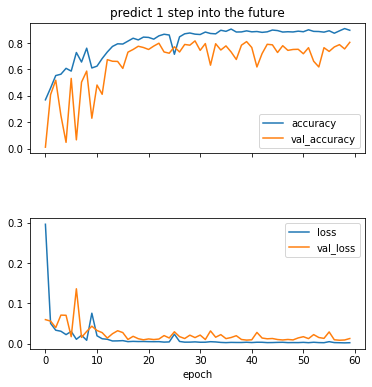

In [52]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.subplots_adjust(hspace=0.5)
ax1.title.set_text(f'predict 1 step into the future')

ax1.plot(hist1.history['accuracy'], label='accuracy')
ax1.plot(hist1.history['val_accuracy'], label='val_accuracy')
ax1.legend()

ax2.plot(hist1.history['loss'], label='loss')
ax2.plot(hist1.history['val_loss'], label='val_loss')
ax2.legend()

ax2.set_xlabel('epoch')
print()

In [53]:
score= model1.evaluate(x, y, verbose=0)
print('Training Loss', score[0])
print('Training  Accuracy', score[1])

Training Loss 0.0040024786499721935
Training  Accuracy 0.8975398540496826


In [54]:
inp = x[-1].reshape((1, dat.shape[0], 200))
p = model1.predict(inp).reshape(dat.shape[0])
# pp = model.predict(inp)
print('recent:     ', inp[0,:,-1])
print('expected:   ', y[-1])
print('prediction: ', p)

recent:      [1.22814289 1.03947544 0.75255751 0.84932703 1.35481928 1.15351054
 0.8224697  0.63808574]
expected:    [1.17919874 1.08005402 0.75967884 0.86297457 1.35366922 1.17960734
 0.86799869 0.69890329]
prediction:  [1.1734813 1.1444919 1.0331713 1.07645   1.5142282 1.2827193 1.0479956
 0.8925612]


(740, 1)
(2959, 1)
1.0828729291242905


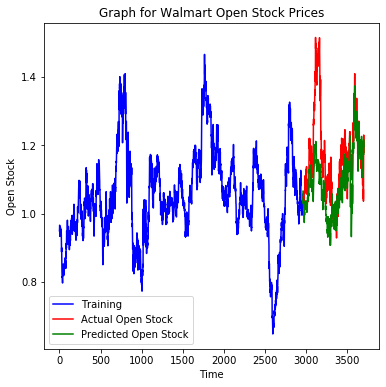

In [55]:
ind =int(0.8*len(y))
dt0=pd.DataFrame(y[:,0])    #first stock
dt=x[:,0:8:,]
train_x, test_x =dt[:ind,0:8:,], dt[ind:,0:8:,]
train_y, test_y =dt0[:ind], dt0[ind:]
pred_y =model1.predict(test_x)
ppy =pred_y[:,0]
#ppy=pd.DataFrame(pred_y[:,0], index=test_y.index)
fc_series =pd.Series(pred_y[:,0], index=test_y.index)
print(test_y.shape)
print(train_y.shape)
# print(fc_.shape)
def conf_int(fc_serie, ci):
#     n=fc_series.count()
    arr=np.array(fc_serie)
    n =len(fc_series)
    #rint(n)
    for i in range(n):
        xbar =np.mean(arr, axis=0)
        
        xstd=np.std(arr, axis=0)
        ts=st.t.ppf((ci +1)/2,n)
        lb =xbar-(ts*(xstd/math.sqrt(n)))
        ub =xbar+(ts*(xstd/math.sqrt(n)))
    return lb, ub
lb, ub =conf_int(ppy,0.95)


#Construct the confidence interval
plt.plot(train_y, 'b')
plt.plot(test_y, 'r')
plt.plot(fc_series, 'g')
#plt.fill_between(fc_series.index, lb,ub, color='k', alpha=0.20)
plt.xlabel('Time')
plt.ylabel('Open Stock')
plt.legend(['Training', 'Actual Open Stock', 'Predicted Open Stock'], loc ='best')
plt.title('Graph for Walmart Open Stock Prices')
print(lb)

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y[-1], p))
mae =mean_absolute_error(y[-1],p)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)

RMSE: 0.170
MAE: 0.149


## Build the LSTM

In [115]:
mod =Sequential()
mod.add(LSTM(440,input_shape=[x.shape[1], x.shape[2]]))
mod.add(Dense(y.shape[1]))
mod.compile(loss=keras.losses.mean_squared_error,
             optimizer=keras.optimizers.Adam(learning_rate=0.01),
             metrics=['accuracy'])
# model.summary()
mod.summary()



Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 440)               1128160   
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 3528      
Total params: 1,131,688
Trainable params: 1,131,688
Non-trainable params: 0
_________________________________________________________________


In [116]:
hist =mod.fit(x, y, batch_size=64,epochs=60, validation_split=0.2, verbose=0)

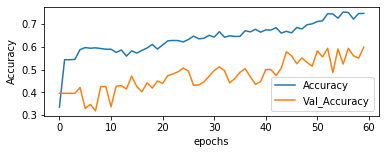

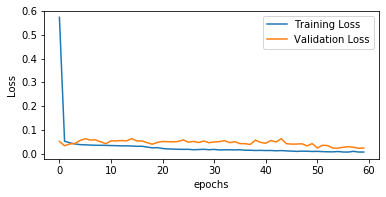

In [117]:
plt.figure(1)
plt.subplot(211)
plt.subplots_adjust(hspace=1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Val_Accuracy'], loc='best')
plt.show()
plt.figure(2)
plt.subplot(212)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='best')
plt.show()


In [118]:
score =mod.evaluate(x, y, verbose=0)
print('Training Loss', score[0])
print('Training  Accuracy', score[1])

Training Loss 0.009436262350012787
Training  Accuracy 0.7445255517959595


In [119]:
inpp = x[-1].reshape((1, dat.shape[0], 200))
pp = mod.predict(inpp).reshape(dat.shape[0])
print('recent:     ', inpp[0,:,-1])
print('expected:   ', y[-1])
print('prediction: ', pp)

recent:      [1.22814289 1.03947544 0.75255751 0.84932703 1.35481928 1.15351054
 0.8224697  0.63808574]
expected:    [1.17919874 1.08005402 0.75967884 0.86297457 1.35366922 1.17960734
 0.86799869 0.69890329]
prediction:  [0.9632517  0.8857788  0.86189264 0.93051255 1.6412946  1.2097222
 0.89028096 0.89047784]


In [120]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y[-1], pp))
mae =mean_absolute_error(y[-1],pp)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)

RMSE: 0.166
MAE: 0.139


## Confidence Interval for Performance Check

(740, 1)
(2959, 1)
1.1610042753329683


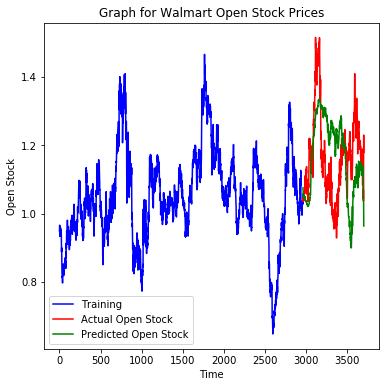

In [121]:
ind =int(0.8*len(y))
dt0=pd.DataFrame(y[:,0])    #first stock
dt=x[:,0:8:,]
train1_x, test1_x =dt[:ind,0:8:,], dt[ind:,0:8:,]
train1_y, test1_y =dt0[:ind], dt0[ind:]
pred1_y =mod.predict(test_x)
ppy =pred1_y[:,0]
#ppy=pd.DataFrame(pred_y[:,0], index=test_y.index)
fc_series1 =pd.Series(pred1_y[:,0], index=test1_y.index)
print(test1_y.shape)
print(train1_y.shape)
# print(fc_.shape)
def conf_int(fc_serie, ci):
#     n=fc_series.count()
    arr=np.array(fc_serie)
    n =len(fc_series)
    #rint(n)
    for i in range(n):
        xbar =np.mean(arr, axis=0)
        
        xstd=np.std(arr, axis=0)
        ts=st.t.ppf((ci +1)/2,n)
        lb =xbar-(ts*(xstd/math.sqrt(n)))
        ub =xbar+(ts*(xstd/math.sqrt(n)))
    return lb, ub
lb, ub =conf_int(ppy,0.95)


#Construct the confidence interval
plt.plot(train1_y, 'b')
plt.plot(test1_y, 'r')
plt.plot(fc_series1, 'g')
#plt.fill_between(fc_series1.index, lb,ub, color='k', alpha=0.20)
plt.xlabel('Time')
plt.ylabel('Open Stock')
plt.legend(['Training', 'Actual Open Stock', 'Predicted Open Stock'], loc ='best')
plt.title('Graph for Walmart Open Stock Prices')
print(lb)